# Task 21

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy

In [2]:
def create_grid(x_bounds, t_bounds, a, x_steps, u_0):
    h = (x_bounds[1] - x_bounds[0]) / x_steps
    k = h / np.abs(a) / 2

    x_grid = np.linspace(*x_bounds, x_steps)
    t_grid = np.arange(*t_bounds, k)

    u_eval = np.zeros((len(x_grid), len(t_grid)), dtype=float)
    u_eval[:, 0] = u_0(x_grid)

    return u_eval, x_grid, t_grid, h, k

In [3]:
def upwind(u_eval, a, k, h):

    for t_ind in range(u_eval.shape[1] - 1):
        u_eval[:-1, t_ind + 1] = u_eval[:-1, t_ind] - \
            a * k * (u_eval[1:, t_ind] - u_eval[:-1, t_ind]) / h
        
        u_eval[-1, t_ind + 1] = u_eval[0, t_ind + 1]
    
    return u_eval

In [4]:
def lax_friedrichs(u_eval, a, k, h):

    for t_ind in range(u_eval.shape[1] - 1):
        u_eval[0, t_ind + 1] = u_eval[0, t_ind] - \
            a * k * (u_eval[1, t_ind] - u_eval[0, t_ind]) / h
        
        u_eval[-1, t_ind + 1] = u_eval[0, t_ind + 1]

        u_eval[1: -1, t_ind + 1] = (u_eval[2:, t_ind] + u_eval[:-2, t_ind]) / 2 - \
            a * k * (u_eval[2:, t_ind] - u_eval[:-2, t_ind]) / 2 / h
    
    return u_eval 

In [26]:
x_bounds = (0, 1)
t_bounds = (0, 10)
a = -1
x_steps = 50
u_0 = lambda x: np.sin(2 * np.pi * x)

# u_eval, x_grid, t_grid, h, k = create_grid(x_bounds, t_bounds, a, x_steps, u_0)

In [27]:
def draw_pictures(x_bounds, t_bounds, a, x_steps, u_0):
    u_eval, x_grid, t_grid, h, k = create_grid(x_bounds, t_bounds, a, x_steps, u_0)
    u_eval_upwind = upwind(u_eval.copy(), a, k, h)
    u_eval_lax = lax_friedrichs(u_eval.copy(), a, k, h)
    u_exact = np.sin(2 * np.pi * np.add.outer(x_grid, t_grid))
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))

    axs[0].set_title(f'Upwind sheme x_steps={x_steps}')
    sns.heatmap(
        pd.DataFrame(
            u_eval_upwind.T[::-1], 
            columns=np.round(x_grid, 2), 
            index=np.round(t_grid[::-1], 2),
        ),
        ax=axs[0]
    )

    axs[1].set_title(f'Lax Friedrichs sheme x_steps={x_steps}')
    sns.heatmap(
        pd.DataFrame(
            u_eval_lax.T[::-1], 
            columns=np.round(x_grid, 2), 
            index=np.round(t_grid[::-1], 2),
        ),
        ax=axs[1]
    )

    axs[2].set_title(f'Exacst solution x_steps={x_steps}')
    sns.heatmap(
        pd.DataFrame(
            u_exact.T[::-1], 
            columns=np.round(x_grid, 2), 
            index=np.round(t_grid[::-1], 2),
        ),
        ax=axs[2]
    )

    axs[0].set_xlabel('x')
    axs[1].set_xlabel('x')
    axs[2].set_xlabel('x')


    axs[0].set_ylabel('t')
    axs[1].set_ylabel('t')
    axs[2].set_ylabel('t')

    plt.show()
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    time = 0.5
    t_ind = int(time / k)

    axs[0].set_title(f'Time {time} x_steps={x_steps}')
    axs[0].plot(x_grid, u_eval_upwind[:, t_ind], label='upwind')
    axs[0].plot(x_grid, u_eval_lax[:, t_ind], label='lax')
    axs[0].plot(x_grid, u_exact[:, t_ind], label='exact')
    axs[0].legend()

    time = 1
    t_ind = int(time / k)

    axs[1].set_title(f'Time {time} x_steps={x_steps}')
    axs[1].plot(x_grid, u_eval_upwind[:, t_ind], label='upwind')
    axs[1].plot(x_grid, u_eval_lax[:, t_ind], label='lax')
    axs[1].plot(x_grid, u_exact[:, t_ind], label='exact')
    axs[1].legend()

    plt.show()

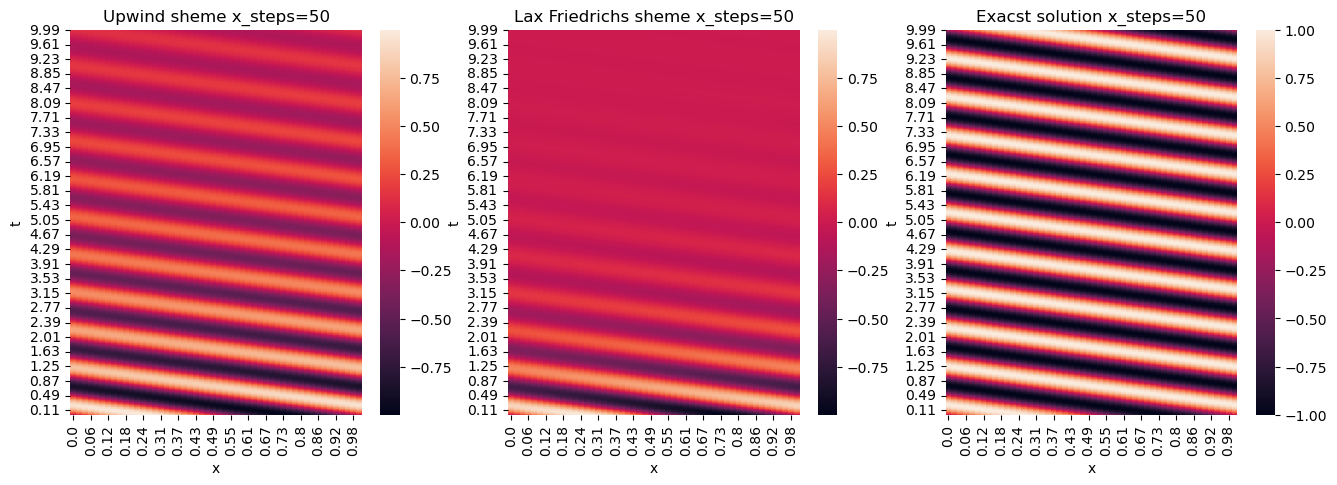

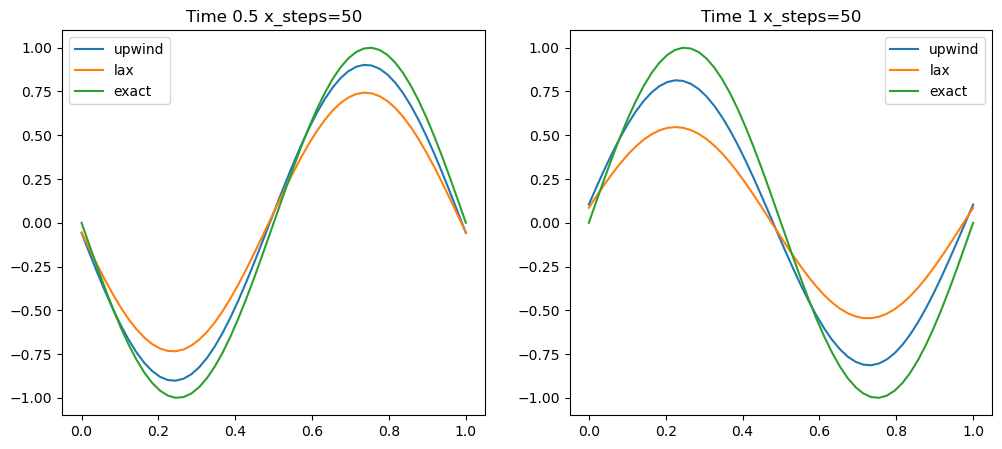

In [28]:
draw_pictures(x_bounds, t_bounds, -1, 50, u_0)

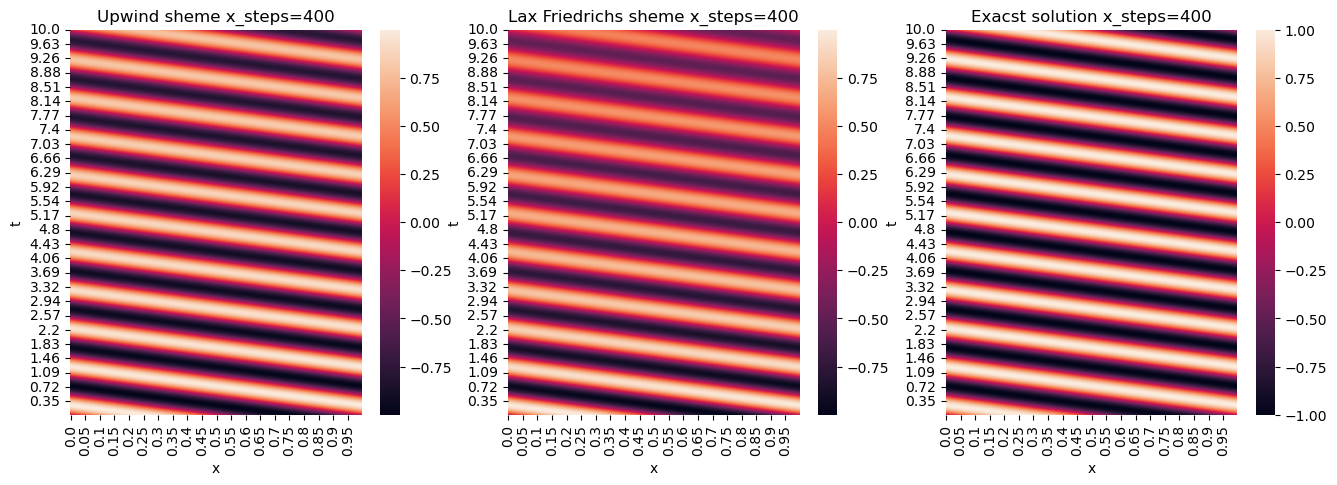

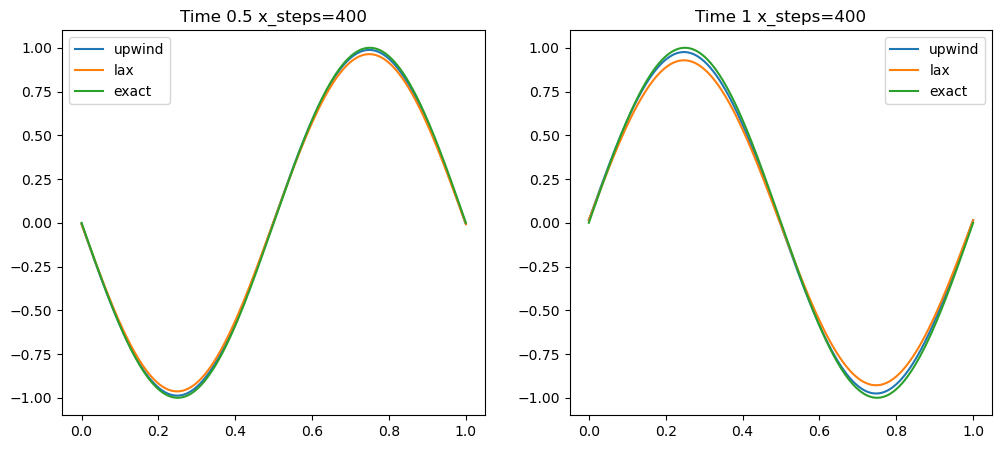

In [29]:
draw_pictures(x_bounds, t_bounds, -1, 400, u_0)

# Task 22

In [127]:
def create_grid_rhs(x_bounds, value_bounds, x_steps, rhs_func):
    x_grid = np.linspace(*x_bounds, x_steps)
    h = (x_bounds[1] - x_bounds[0]) / x_steps

    u_rhs = rhs_func(x_grid)
    u_rhs *= h ** 2
    u_rhs[0], u_rhs[-1] = value_bounds

    return u_rhs, x_grid, h

In [128]:
x_bounds = 0, 1
value_bounds = 1, 1
x_steps = 200
rhs_func = lambda x: -np.cos(np.pi * x)

In [129]:
def finite_diff(u_rhs, h):
    x_steps = len(u_rhs)
    D = np.diag(np.ones(x_steps)) * -2
    D += np.diag(np.ones(x_steps - 1), 1)
    D += np.diag(np.ones(x_steps - 1), -1)

    D[0, 0] = 1
    D[0, 1] = 0
    D[-1, -1] = 1
    D[-1, -2] = 0

    u = scipy.linalg.solve(D, u_rhs)

    return u

In [130]:
u_rhs, x_grid, h = create_grid_rhs(x_bounds, value_bounds, x_steps, rhs_func)
u_fdiff = finite_diff(u_rhs, h)
real_u_func = lambda x: (2 * x + np.cos(np.pi * x) - 1) / (np.pi ** 2) + 1
real_u_eval = real_u_func(x_grid)

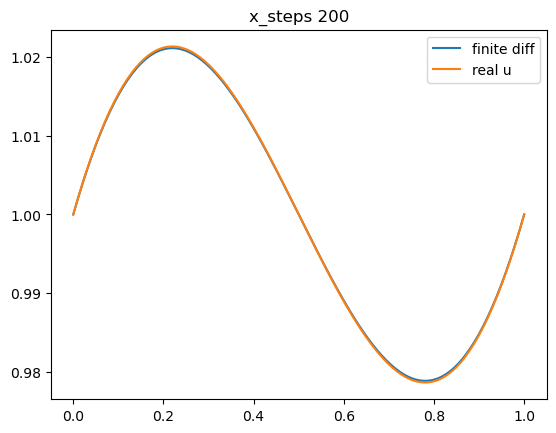

In [131]:
plt.title(f'x_steps {x_steps}')
plt.plot(x_grid, u_fdiff, label='finite diff')
plt.plot(x_grid, real_u_eval, label='real u')
plt.legend()
plt.show()

In [132]:
np.max(np.abs(u_fdiff - real_u_eval))

0.00021231519854614245

In [133]:
np.exp2(np.arange(7)).astype(int) * 20

array([  20,   40,   80,  160,  320,  640, 1280])

In [134]:
x_steps_vars = [20, 40, 80, 160, 320, 640, 1280]
errors = []

for x_steps in x_steps_vars:
    u_rhs, x_grid, h = create_grid_rhs(x_bounds, value_bounds, x_steps, rhs_func)
    u_fdiff = finite_diff(u_rhs, h)
    real_u_func = lambda x: (2 * x + np.cos(np.pi * x) - 1) / (np.pi ** 2) + 1
    real_u_eval = real_u_func(x_grid)
    errors.append(np.max(np.abs(u_fdiff - real_u_eval)))

In [135]:
errors

[0.0020326090759787974,
 0.0010398765925898612,
 0.000526971484391181,
 0.00026509920116946084,
 0.00013292959135313698,
 6.655936504196269e-05,
 3.330360708164726e-05]

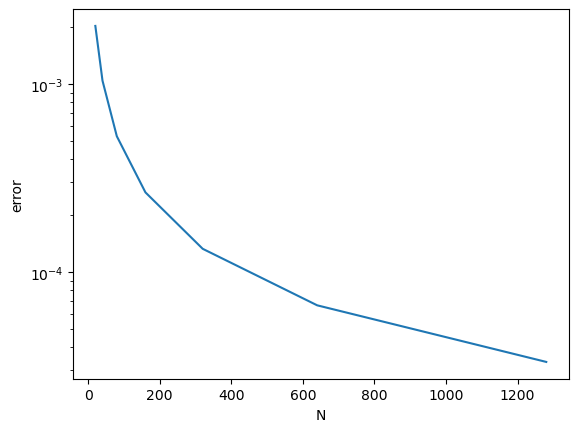

In [136]:
plt.plot(x_steps_vars, errors)
plt.xlabel('N')
plt.ylabel('error')
plt.yscale('log')
plt.show()

# Task 23

In [90]:
x_bounds = y_bounds = 0, 1
N = 40

x_grid = np.linspace(*x_bounds, N)
y_grid = np.linspace(*y_bounds, N)
h = (x_bounds[1] - x_bounds[0]) / N

x_mesh, y_mesh = np.meshgrid(x_grid, y_grid)

boundary_func = lambda x, y: np.sin(x * y)
inside_func = lambda x, y: -np.sin(x * y) * (x ** 2 + y ** 2) / (h ** 2)

boundary_mesh = boundary_func(x_mesh, y_mesh)
inside_mesh = inside_func(x_mesh, y_mesh)

In [109]:
from itertools import combinations_with_replacement

In [114]:
# u[i, j] -> D[i * N + j]

D = np.zeros((N * N, N * N))

# TODO: Make it without loops
for i, j in combinations_with_replacement(range(N - 1), 2):

    if i == 2 and j == 1:
        print('HEY')

    D[i * N + j, i * N + j] = -4
    D[i * N + j, (i + 1) * N + j] = 1
    D[i * N + j, (i - 1) * N + j] = 1
    D[i * N + j, i * N + j + 1] = 1
    D[i * N + j, i * N + j - 1] = 1


boundary_flat = boundary_mesh.reshape(-1)
inside_flat = inside_mesh.reshape(-1)

rhs = inside_flat.copy()

for i in range(N):
    # u[i, 0] 
    D[i * N, i * N] = 1

    # u[i, -1]
    D[i * N + N - 1, i * N + N - 1] = 1

    # u[0, i]
    D[i, i] = 1

    # u[-1, i]
    D[(N - 1) * N + i, (N - 1) * N + i] = 1

    rhs[i * N] = boundary_flat[i * N]
    rhs[i * N + N - 1] = boundary_flat[i * N + N - 1]
    rhs[i] = boundary_flat[i]
    rhs[(N - 1) * N + i] = boundary_flat[(N - 1) * N + i]


In [113]:
np.arange(len(np.diag(D)))[np.abs(np.diag(D)) < 1]

array([  81,  121,  122,  161,  162,  163,  201,  202,  203,  204,  241,
        242,  243,  244,  245,  281,  282,  283,  284,  285,  286,  321,
        322,  323,  324,  325,  326,  327,  361,  362,  363,  364,  365,
        366,  367,  368,  401,  402,  403,  404,  405,  406,  407,  408,
        409,  441,  442,  443,  444,  445,  446,  447,  448,  449,  450,
        481,  482,  483,  484,  485,  486,  487,  488,  489,  490,  491,
        521,  522,  523,  524,  525,  526,  527,  528,  529,  530,  531,
        532,  561,  562,  563,  564,  565,  566,  567,  568,  569,  570,
        571,  572,  573,  601,  602,  603,  604,  605,  606,  607,  608,
        609,  610,  611,  612,  613,  614,  641,  642,  643,  644,  645,
        646,  647,  648,  649,  650,  651,  652,  653,  654,  655,  681,
        682,  683,  684,  685,  686,  687,  688,  689,  690,  691,  692,
        693,  694,  695,  696,  721,  722,  723,  724,  725,  726,  727,
        728,  729,  730,  731,  732,  733,  734,  7

In [112]:
np.linalg.solve(D, rhs)

LinAlgError: Singular matrix

In [70]:

# u_eval_matrix = np.zeros((x_steps, y_steps))

# u_eval_matrix[0] = z_mesh[0]
# u_eval_matrix[-1] = z_mesh[-1]
# u_eval_matrix[:, 0] = z_mesh[:, 0]
# u_eval_matrix[:, -1] = z_mesh[:, -1]

array([[0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.24740396],
       [0.        , 0.        , 0.        , 0.        , 0.47942554],
       [0.        , 0.        , 0.        , 0.        , 0.68163876],
       [0.        , 0.24740396, 0.47942554, 0.68163876, 0.84147098]])

In [58]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

In [66]:
fig = go.Figure(
    data=[
        go.Surface(
            x=x_mesh, 
            y=y_mesh, 
            z=z_mesh, 
            surfacecolor=np.ones_like(x_mesh), 
            showscale=False
        ),

    ],
)

# fig.update_layout(
#     title={
#         'text': f'GD converged to flat minima lr=0.01', 
#         'x':0.5,
#         'xanchor': 'center',
#     }
# )

fig.show()